In [1]:
import pandas as pd

bloomberg_df = pd.read_csv('/Users/kirillsakharov/Desktop/untitled folder/Bloomberg_cleaned.csv')
reddit_df = pd.read_csv('reddit_filtered_companies3.csv')

/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_73779/34629334.py:4: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_df = pd.read_csv('reddit_filtered_companies3.csv')


In [2]:
bloomberg_df = bloomberg_df.drop('Unnamed: 0', axis=1)

In [3]:
bloomberg_df = bloomberg_df.drop('target', axis=1)

In [4]:
reddit_df = reddit_df.rename(columns={'created_utc': 'Dates'})

In [5]:

reddit_df['Dates'] = pd.to_datetime(reddit_df['Dates'], unit='s')
bloomberg_df['Dates'] = pd.to_datetime(bloomberg_df['Dates'])
reddit_df = reddit_df.rename(columns={'company': 'Company'})

In [6]:
reddit_df['Dates'] = reddit_df['Dates'].dt.date

In [7]:
bloomberg_df['Dates'] = bloomberg_df['Dates'].dt.date

In [8]:
reddit_df['Dates'] = pd.to_datetime(reddit_df['Dates'])

reddit_df['Dates'] = reddit_df['Dates'].apply(lambda x: x + pd.DateOffset(days=1) if x.dayofweek == 6 else (x + pd.DateOffset(days=2) if x.dayofweek == 5 else x))

In [9]:
reddit_df['Dates'] = pd.to_datetime(reddit_df['Dates'])
bloomberg_df['Dates'] = pd.to_datetime(bloomberg_df['Dates'])


In [10]:
merged_df = pd.merge(reddit_df, bloomberg_df, on=['Dates', 'Company'])

In [14]:
merged_df = merged_df.dropna()


In [ ]:
df_copy = merged_df.copy()

df_copy['Dates'] = pd.to_datetime(df_copy['Dates'])

grouped_df = df_copy.groupby(['Dates', 'Company']).agg({'body':'count', 'score':'mean', 'sentiment':'mean'}).reset_index()

grouped_df.rename(columns={'body': 'Comments Count', 'score': 'Average_Comment_Score', 'sentiment': 'COVID_sentiment'}, inplace=True)

df_copy.drop_duplicates(['Dates', 'Company'], keep='first', inplace=True)

df_copy = pd.merge(df_copy, grouped_df, on=['Dates', 'Company'])


In [16]:
backup = df_copy

In [17]:
df_copy.to_csv('Final_Data.csv')

In [19]:
train_start_date = pd.to_datetime('2019-01-01')
train_end_date = pd.to_datetime('2021-05-14')
val_start_date = pd.to_datetime('2021-05-15')
val_end_date = pd.to_datetime('2021-07-15')
test_start_date = pd.to_datetime('2021-07-17')
test_end_date = pd.to_datetime('2021-11-30')

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

financial_features = ['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 
                      'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Price Earnings Ratio (P/E)', 
                      'Return on Common Equity', 'Total Debt to Total Equity']

bloomberg_sentiment_features = ['Twitter Sentiment Daily Average', 'News Sentiment - Daily Average',
                               'Twitter Publication Count', 'News Heat - Daily Average Story Flow',
                                'News Publication Count']

reddit_features = ['Comments Count', 'Average_Comment_Score', 'COVID_sentiment']

esg_features = ['ESG News Sentiment ES Negative', 'ESG News Sentiment ES Positive',
               'ESG News Count ES Negative', 'ESG News Count ES Positive']

model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)

features_list = [financial_features, 
                 financial_features + bloomberg_sentiment_features, 
                 financial_features + reddit_features, 
                 financial_features + esg_features,
                 financial_features + bloomberg_sentiment_features + reddit_features,
                 financial_features + bloomberg_sentiment_features + esg_features,
                 financial_features + reddit_features + esg_features,
                 financial_features + bloomberg_sentiment_features + reddit_features + esg_features]

labels = ['Financial', 
          'Financial + Bloomberg Sentiment', 
          'Financial + Reddit', 
          'Financial + ESG',
          'Financial + Bloomberg Sentiment + Reddit',
          'Financial + Bloomberg Sentiment + ESG', 
          'Financial + Reddit + ESG',
          'Financial + Bloomberg Sentiment + Reddit + ESG']

n_estimators = [50, 100, 150]
max_depths = [5, 7, 9]
min_samples_splits = [2, 4, 6, 8, 10]

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['1 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 8:
Accuracy: 0.5223274695534507
Precision: 0.5469798657718121
Recall: 0.36093888396811336
F1 Score: 0.43489861259338314
ROC AUC: 0.5385714966068358

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 10:
Accuracy: 0.5121786197564276
Precision: 0.5265214963707426
Recall: 0.41762621789193977
F1 Score: 0.46579402321560875
ROC AUC: 0.5263406784048872

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5196211096075778
Precision: 0.535754189944134
Recall: 0.4247121346324181
F1 Score: 0.47381422924901184
ROC AUC: 0.5320918800148492

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 50, max_depth = 9, min_samples_split = 8:
Accuracy: 0.5142083897158322
Precision: 0.5333761232349166
Recall: 0.368024800

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['2 Day Future Return'] > 0


train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 9, min_samples_split = 8:
Accuracy: 0.523680649526387
Precision: 0.5334728033472803
Recall: 0.5611795774647887
F1 Score: 0.5469755469755471
ROC AUC: 0.5302394268478587

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 6:
Accuracy: 0.5155615696887687
Precision: 0.5210027100271003
Recall: 0.6769366197183099
F1 Score: 0.5888208269525268
ROC AUC: 0.5300404269976938

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 100, max_depth = 5, min_samples_split = 2:
Accuracy: 0.514659449706811
Precision: 0.5194805194805194
Recall: 0.704225352112676
F1 Score: 0.5979073243647235
ROC AUC: 0.5252215769175645

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 100, max_depth = 5, min_samples_split = 4:
Accuracy: 0.5223274695534507
Precision: 0.5234327449786975
Recall: 0.75704225352112

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


df_copy['target'] = df_copy['3 Day Future Return'] > 0


train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]



for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 150, max_depth = 5, min_samples_split = 8:
Accuracy: 0.531574199368516
Precision: 0.5359477124183006
Recall: 0.8094420600858369
F1 Score: 0.6448965635151308
ROC AUC: 0.5289290580786239

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5297699594046008
Precision: 0.5370874962155616
Recall: 0.76137339055794
F1 Score: 0.6298597550150896
ROC AUC: 0.5322257624961243

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 6:
Accuracy: 0.5399188092016238
Precision: 0.5397478070175439
Recall: 0.8450643776824034
F1 Score: 0.6587487453997993
ROC AUC: 0.5280565120187992

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 8:
Accuracy: 0.5299954894000902
Precision: 0.536563614744352
Recall: 0.774678111587982

In [101]:
df_copy = backup

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['3 Day Future Return'] > 0

top_10_companies = df_copy['Company'].value_counts().index[:10]

backup = df_copy

# Filter the data for only these top 10 companies
df_copy = df_copy[df_copy['Company'].isin(top_10_companies)]
num_rows = df_copy.shape[0]
print(f'There are {num_rows} rows in the DataFrame.')

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]



for features, label in zip(features_list, labels):


    best_accuracy = -1
    best_params = None

   
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
               
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    

    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)


    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

There are 4473 rows in the DataFrame.
Testing Metrics with Financial and best hyperparameters n_estimator = 100, max_depth = 9, min_samples_split = 2:
Accuracy: 0.4943661971830986
Precision: 0.551094890510949
Recall: 0.39018087855297157
F1 Score: 0.4568835098335855
ROC AUC: 0.5330757353941168

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 6:
Accuracy: 0.5070422535211268
Precision: 0.5579937304075235
Recall: 0.4599483204134367
F1 Score: 0.5042492917847026
ROC AUC: 0.5156758745930032

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 100, max_depth = 5, min_samples_split = 8:
Accuracy: 0.5450704225352113
Precision: 0.564
Recall: 0.7286821705426356
F1 Score: 0.6358511837655016
ROC AUC: 0.5119559043527653

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 50, max_depth = 9, min_samples_split = 2:
Accuracy: 0.5295774647887324
Precision: 0.57422969187675

In [53]:
import matplotlib.pyplot as plt

df_copy['target'] = df_copy['3 Day Future Return'] > 0

pd.set_option('display.max_rows', None)

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

train_val_data = pd.concat([train_data, val_data])

best_params = [
    (150, 5, 8),
    (100, 7, 2)
]

features_list = [
    financial_features, 
                 financial_features + reddit_features, 
]

results_dfs = []
for features, params in zip(features_list, best_params):

    model = RandomForestClassifier(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2], random_state=42)
    model.fit(train_val_data[features], train_val_data['target'])


    test_data['predictions'] = model.predict(test_data[features])


    results = []
    companies = test_data['Company'].unique()
    for company in companies:
        company_data = test_data[test_data['Company'] == company]
        accuracy = accuracy_score(company_data['target'], company_data['predictions'])
        results.append((company, accuracy))


    results_df = pd.DataFrame(results, columns=['Company', 'Accuracy']).sort_values('Accuracy', ascending=False)
    results_dfs.append(results_df)

merged_df = results_dfs[0].merge(results_dfs[1], on='Company', suffixes=('_before', '_after'))

merged_df['accuracy_diff'] = merged_df['Accuracy_after'] - merged_df['Accuracy_before']

largest_changes = merged_df.sort_values('accuracy_diff', ascending=False)

print(largest_changes[['Company', 'accuracy_diff']])


/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/3502901703.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


                            Company  accuracy_diff
75                             HSBC       0.250000
51                          Allianz       0.242424
21                 General Electric       0.200000
72                          L'oreal       0.200000
62                       CVS Health       0.169014
57                          Walmart       0.154930
68                            Intel       0.126761
50                          Verizon       0.073171
63                            Lexus       0.068182
73                      T-Mobile US       0.067797
31                          Samsung       0.063492
41                          Porsche       0.062500
46                  Bank of America       0.056338
65                            FedEx       0.056338
56                             Meta       0.056338
16                      Wells Fargo       0.051282
60                              AXA       0.042254
67                             Zara       0.031250
11                           Da

/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/3502901703.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


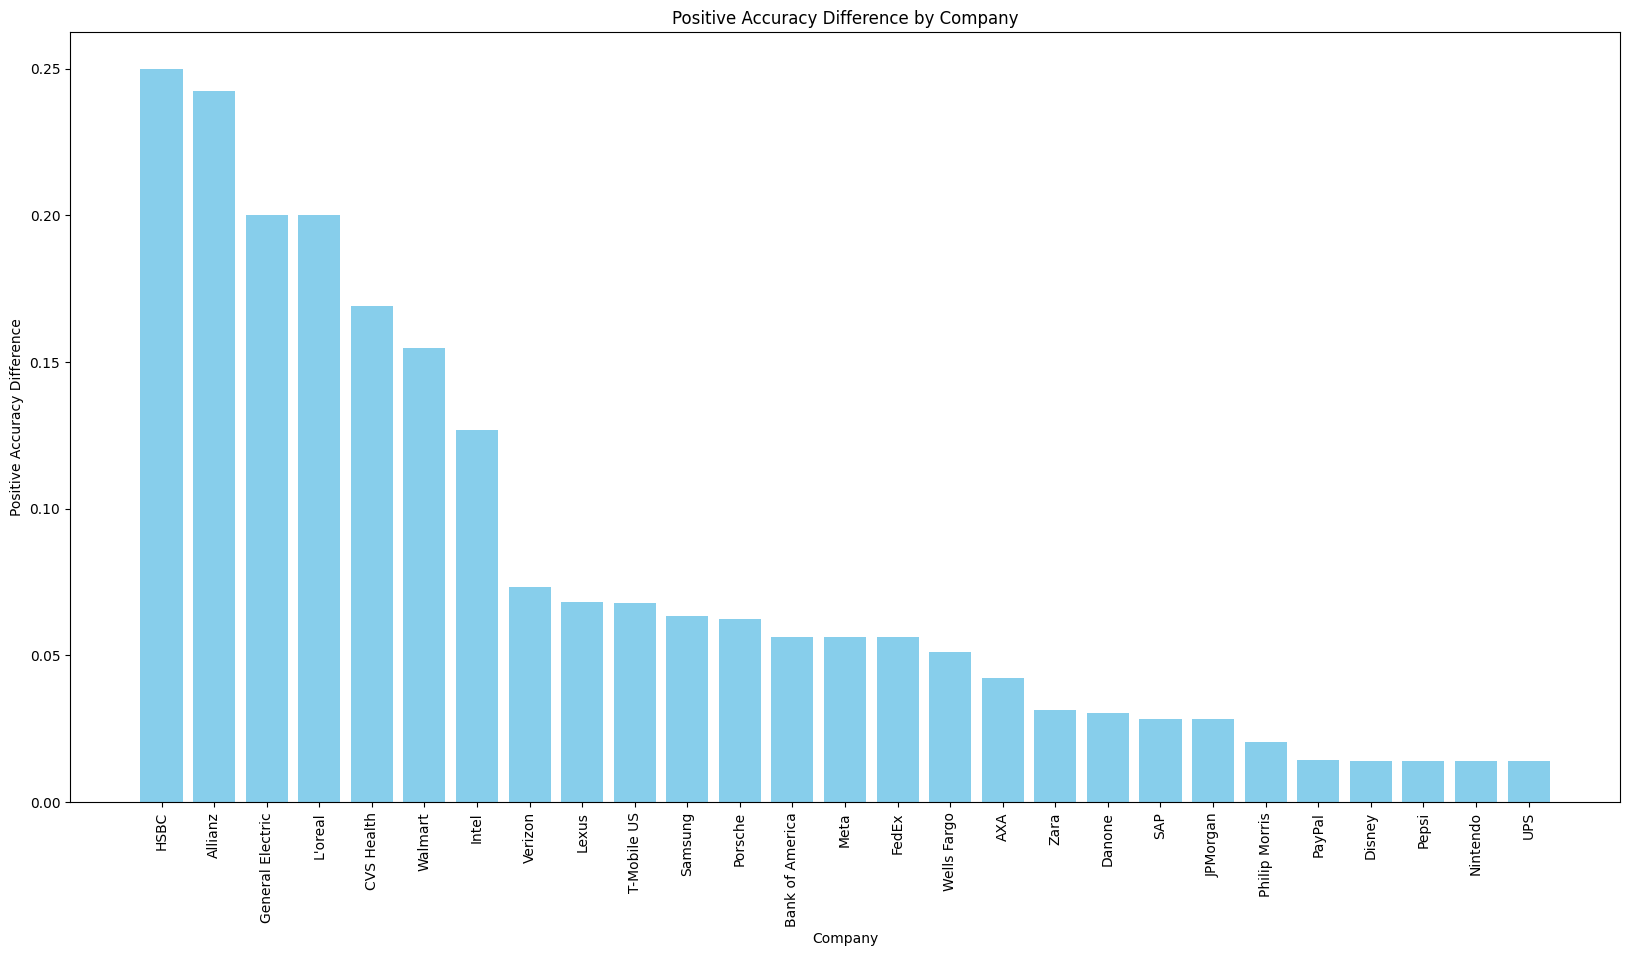

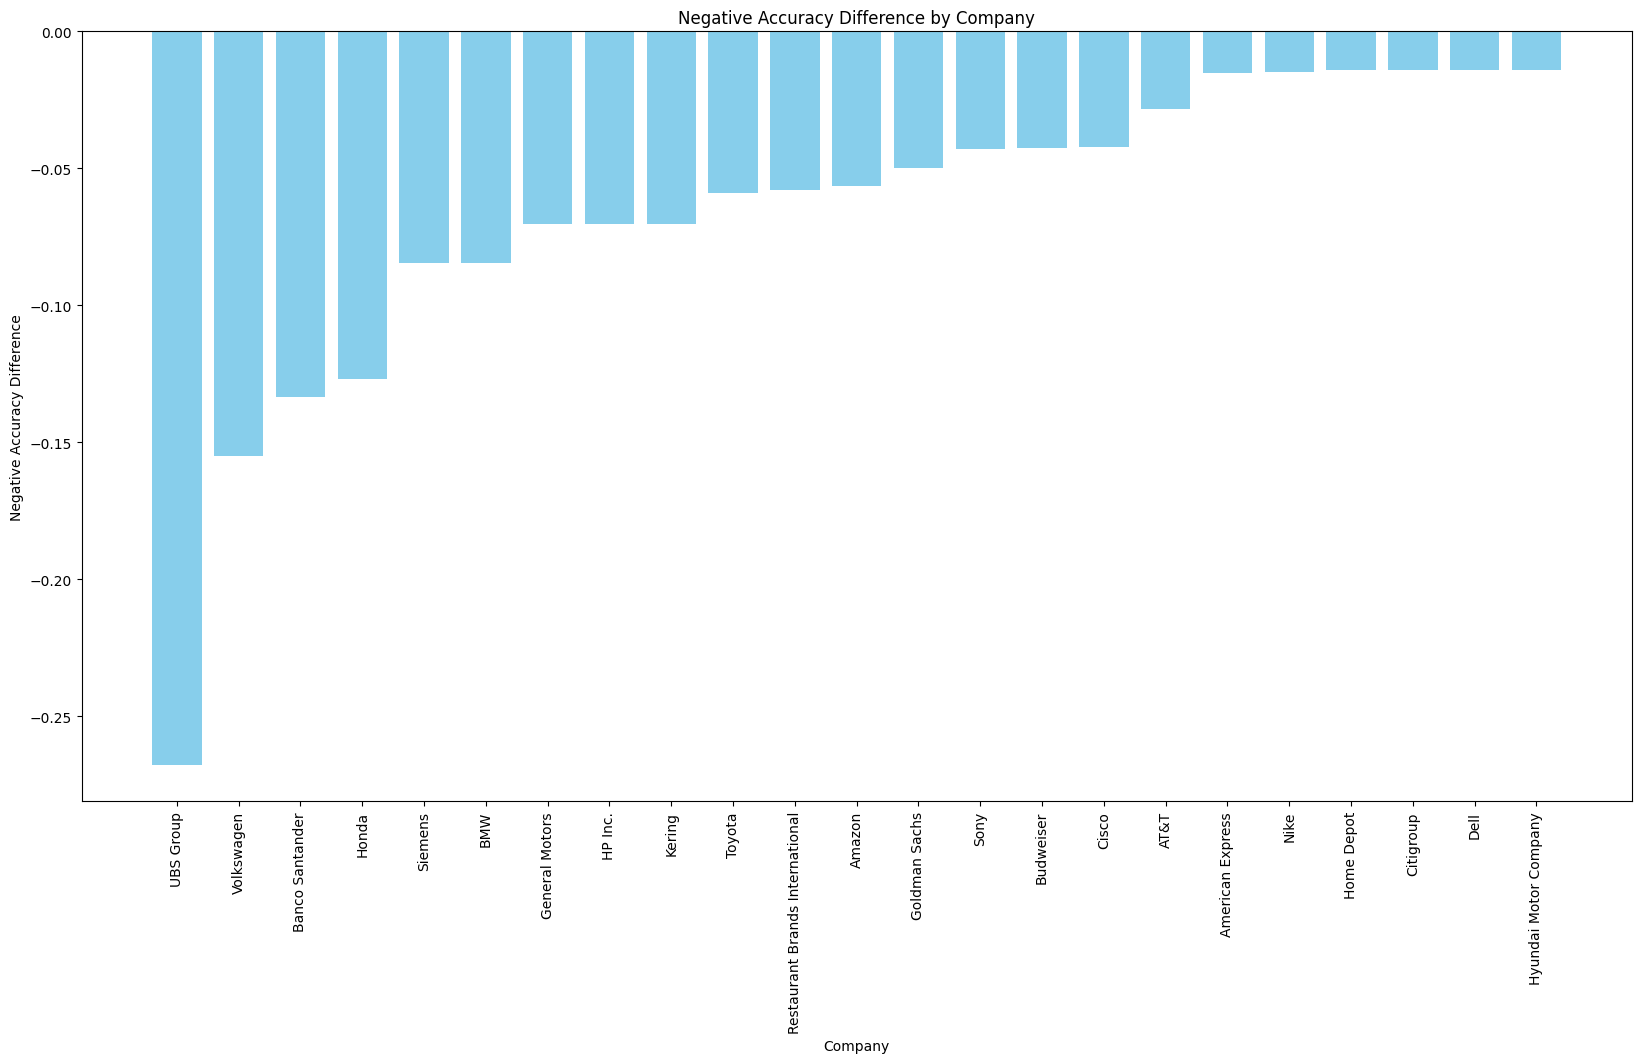

In [108]:
import matplotlib.pyplot as plt

df_positive = largest_changes[largest_changes['accuracy_diff'] > 0].sort_values('accuracy_diff', ascending=False)
df_negative = largest_changes[largest_changes['accuracy_diff'] < 0].sort_values('accuracy_diff')

plt.figure(figsize=(20,10)) 
plt.bar(df_positive['Company'], df_positive['accuracy_diff'], color='skyblue')
plt.xlabel('Company')
plt.ylabel('Positive Accuracy Difference')
plt.title('Positive Accuracy Difference by Company')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20,10)) 
plt.bar(df_negative['Company'], df_negative['accuracy_diff'], color='skyblue')
plt.xlabel('Company')
plt.ylabel('Negative Accuracy Difference')
plt.title('Negative Accuracy Difference by Company')
plt.xticks(rotation=90)
plt.show()


In [56]:
df_copy['target'] = df_copy['3 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

pd.set_option('display.max_rows', None)

train_val_data = pd.concat([train_data, val_data])

best_params = [
    (150, 5, 8),
    (100, 7, 2),
    (50, 5, 6)
]

features_list = [
    financial_features, 
    financial_features + bloomberg_sentiment_features, 
    financial_features + reddit_features, 
]

top_20_companies = df_copy['Company'].value_counts().index[:10]

for features, params in zip(features_list, best_params):

    model = RandomForestClassifier(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2], random_state=42)
    model.fit(train_val_data[features], train_val_data['target'])

   
    test_data['predictions'] = model.predict(test_data[features])


    results = []
    companies = test_data['Company'].unique()
    for company in companies:
        if company not in top_20_companies:
            continue
        company_data = test_data[test_data['Company'] == company]
        accuracy = accuracy_score(company_data['target'], company_data['predictions'])
        results.append((company, accuracy))


    results_df = pd.DataFrame(results, columns=['Company', 'Accuracy']).sort_values('Accuracy', ascending=False)
    

    avg_accuracy = results_df['Accuracy'].mean()

    print(f'Ranking of companies by prediction accuracy with feature set "{features}":')
    print(results_df)
    print(f'\nAverage accuracy: {avg_accuracy}\n')


/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/2587750374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


Ranking of companies by prediction accuracy with feature set "['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Price Earnings Ratio (P/E)', 'Return on Common Equity', 'Total Debt to Total Equity']":
           Company  Accuracy
8        UBS Group  0.676056
0           Google  0.619718
5          HP Inc.  0.605634
1            Honda  0.591549
6             Ford  0.535211
7            Apple  0.521127
3  Bank of America  0.492958
4              UPS  0.492958
9              SAP  0.478873
2             Meta  0.464789

Average accuracy: 0.5478873239436619



/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/2587750374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


Ranking of companies by prediction accuracy with feature set "['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Price Earnings Ratio (P/E)', 'Return on Common Equity', 'Total Debt to Total Equity', 'Twitter Sentiment Daily Average', 'News Sentiment - Daily Average', 'Twitter Publication Count', 'News Heat - Daily Average Story Flow', 'News Publication Count']":
           Company  Accuracy
0           Google  0.633803
5          HP Inc.  0.605634
8        UBS Group  0.549296
6             Ford  0.535211
7            Apple  0.521127
2             Meta  0.492958
3  Bank of America  0.492958
4              UPS  0.492958
9              SAP  0.478873
1            Honda  0.464789

Average accuracy: 0.5267605633802817

Ranking of companies by prediction accuracy with feature set "['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Pric

/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/2587750374.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


In [59]:
df_copy['target'] = df_copy['3 Day Future Return'] > 0

top_10_companies = df_copy['Company'].value_counts().index[:20]

df_copy = df_copy[df_copy['Company'].isin(top_10_companies)]

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

pd.set_option('display.max_rows', None)

train_val_data = pd.concat([train_data, val_data])

best_params = [
    (150, 5, 8),
    (100, 3, 2),
    (50, 5, 6)
]

features_list = [
    financial_features, 
    financial_features + bloomberg_sentiment_features, 
    financial_features + reddit_features, 
]

for features, params in zip(features_list, best_params):

    model = RandomForestClassifier(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2], random_state=42)
    model.fit(train_val_data[features], train_val_data['target'])


    test_data['predictions'] = model.predict(test_data[features])

    overall_accuracy = accuracy_score(test_data['target'], test_data['predictions'])


    print(f'Overall accuracy with feature set "{features}": {overall_accuracy}\n')


/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/447677057.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


Overall accuracy with feature set "['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Price Earnings Ratio (P/E)', 'Return on Common Equity', 'Total Debt to Total Equity']": 0.5267605633802817

Overall accuracy with feature set "['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Price Earnings Ratio (P/E)', 'Return on Common Equity', 'Total Debt to Total Equity', 'Twitter Sentiment Daily Average', 'News Sentiment - Daily Average', 'Twitter Publication Count', 'News Heat - Daily Average Story Flow', 'News Publication Count']": 0.5605633802816902

Overall accuracy with feature set "['Basic Earnings per Share', 'Last Price', 'Open Price', 'Volatility 10 Day', 'Volatility 30 Day', 'Volatility 90 Day', 'Volume', 'Price Earnings Ratio (P/E)', 'Return on Common Equity', 'Total Debt to Total Equity', 'Comments Count', 'Average Sentiment

/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/447677057.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])
/var/folders/_w/t13tb9qx6qsfqhrwbncrcc040000gn/T/ipykernel_39021/447677057.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = model.predict(test_data[features])


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['7 Day Future Return'] > 0


train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):


    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)

    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 8:
Accuracy: 0.5279657194406856
Precision: 0.5395863052781741
Recall: 0.6535637149028077
F1 Score: 0.591131080289119
ROC AUC: 0.5357175692107916

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 10:
Accuracy: 0.5252593594948128
Precision: 0.5363573407202216
Recall: 0.6691144708423327
F1 Score: 0.5954257159331156
ROC AUC: 0.5349705482740238

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 2:
Accuracy: 0.530446549391069
Precision: 0.5409490333919157
Recall: 0.6647948164146869
F1 Score: 0.5965116279069768
ROC AUC: 0.5393611436993488

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5189445196211097
Precision: 0.5307017543859649
Recall: 0.67948164146

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['15 Day Future Return'] > 0


train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)

    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5313486693730266
Precision: 0.533195020746888
Recall: 0.7814943527367506
F1 Score: 0.6338971106412966
ROC AUC: 0.5475927002052217

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5272891294542175
Precision: 0.5283902976846747
Recall: 0.8327541268462206
F1 Score: 0.6465430016863406
ROC AUC: 0.5423768873791124

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 10:
Accuracy: 0.534957149300857
Precision: 0.5305966343702193
Recall: 0.9039965247610773
F1 Score: 0.6687017994858612
ROC AUC: 0.5458475418226748

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 8:
Accuracy: 0.5115020297699594
Precision: 0.5183684494867639
Recall: 0.8336229365768

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['30 Day Future Return'] > 0

from datetime import datetime, timedelta
train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date + timedelta(days=30)) & (df_copy['Dates'] <= test_end_date)]

for features, label in zip(features_list, labels):


    best_accuracy = -1
    best_params = None


    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
   
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 6:
Accuracy: 0.5197616060225847
Precision: 0.5360344209394048
Recall: 0.8631639722863741
F1 Score: 0.6613581066135811
ROC AUC: 0.49211751008806437

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 4:
Accuracy: 0.560853199498118
Precision: 0.554177545691906
Recall: 0.9803695150115473
F1 Score: 0.7080900750625522
ROC AUC: 0.523463275321676

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 9, min_samples_split = 8:
Accuracy: 0.5357590966122961
Precision: 0.548951048951049
Recall: 0.8158198614318707
F1 Score: 0.6562935438922434
ROC AUC: 0.5066022495114585

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 10:
Accuracy: 0.541405269761606
Precision: 0.5471039776692254
Recall: 0.9053117782909931


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['1 Day Future Return'] > 0

from datetime import datetime, timedelta
train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date + timedelta(days=1)) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 8:
Accuracy: 0.5223274695534507
Precision: 0.5469798657718121
Recall: 0.36093888396811336
F1 Score: 0.43489861259338314
ROC AUC: 0.5385714966068358

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 10:
Accuracy: 0.5121786197564276
Precision: 0.5265214963707426
Recall: 0.41762621789193977
F1 Score: 0.46579402321560875
ROC AUC: 0.5263406784048872

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5196211096075778
Precision: 0.535754189944134
Recall: 0.4247121346324181
F1 Score: 0.47381422924901184
ROC AUC: 0.5320918800148492

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 50, max_depth = 9, min_samples_split = 8:
Accuracy: 0.5142083897158322
Precision: 0.5333761232349166
Recall: 0.368024800

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['3 Day Future Return'] > 0

from datetime import datetime, timedelta
train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date + timedelta(days=3)) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
 
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    

    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)


    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 150, max_depth = 5, min_samples_split = 8:
Accuracy: 0.5287514318442154
Precision: 0.53121387283237
Recall: 0.8086229652441707
F1 Score: 0.6412000697714983
ROC AUC: 0.5281267586321763

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5266895761741123
Precision: 0.5318559556786704
Recall: 0.7602287725472944
F1 Score: 0.6258601955813111
ROC AUC: 0.5307296394031187

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 6:
Accuracy: 0.5367697594501718
Precision: 0.5350069735006974
Recall: 0.8438187417509899
F1 Score: 0.6548310003414135
ROC AUC: 0.5266812628756059

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 8:
Accuracy: 0.52737686139748
Precision: 0.5317220543806647
Recall: 0.774307083150022

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['7 Day Future Return'] > 0

from datetime import datetime, timedelta
train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date + timedelta(days=7)) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None


    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
                
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 8:
Accuracy: 0.5267360270989596
Precision: 0.5316455696202531
Recall: 0.6534653465346535
F1 Score: 0.5862944162436549
ROC AUC: 0.5361465108453475

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 10:
Accuracy: 0.5226227921606581
Precision: 0.5275707898658718
Recall: 0.6676096181046676
F1 Score: 0.5893860561914673
ROC AUC: 0.5351099438259646

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5296394870554076
Precision: 0.5334340763128069
Recall: 0.6657237152286657
F1 Score: 0.5922818791946308
ROC AUC: 0.5391037790231735

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 150, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5158480522622793
Precision: 0.5217391304347826
Recall: 0.678925035

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['15 Day Future Return'] > 0

from datetime import datetime, timedelta
train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date + timedelta(days=15)) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
                
        
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)

    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5246073298429319
Precision: 0.5246636771300448
Recall: 0.776416539050536
F1 Score: 0.6261836146562371
ROC AUC: 0.5451057533822732

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 2:
Accuracy: 0.5232984293193718
Precision: 0.5221437740693197
Recall: 0.8305257784583971
F1 Score: 0.6411822660098522
ROC AUC: 0.5358503266451783

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 10:
Accuracy: 0.5321989528795812
Precision: 0.5255496137849079
Recall: 0.9030117406840225
F1 Score: 0.6644131455399062
ROC AUC: 0.5535584533994715

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 100, max_depth = 7, min_samples_split = 8:
Accuracy: 0.5081151832460733
Precision: 0.5125549278091651
Recall: 0.833588565594

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

df_copy['target'] = df_copy['30 Day Future Return'] > 0


train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]


for features, label in zip(features_list, labels):

    best_accuracy = -1
    best_params = None

    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                model = RandomForestClassifier(n_estimators=n_estimator, 
                                               max_depth=max_depth, 
                                               min_samples_split=min_samples_split, 
                                               random_state=42)

                model.fit(train_data[features], train_data['target'])
                val_predictions = model.predict(val_data[features])
                val_accuracy = accuracy_score(val_data['target'], val_predictions)
    
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = (n_estimator, max_depth, min_samples_split)
                    
    best_model = RandomForestClassifier(n_estimators=best_params[0], 
                                        max_depth=best_params[1], 
                                        min_samples_split=best_params[2], 
                                        random_state=42)

    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)
    
    print(f'Testing Metrics with {label} and best hyperparameters n_estimator = {best_params[0]}, max_depth = {best_params[1]}, min_samples_split = {best_params[2]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')
    

Testing Metrics with Financial and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 6:
Accuracy: 0.5166892196662156
Precision: 0.5214359504132231
Recall: 0.8744045041143352
F1 Score: 0.653292347516583
ROC AUC: 0.5318032252311925

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters n_estimator = 50, max_depth = 5, min_samples_split = 4:
Accuracy: 0.5448804691023906
Precision: 0.5341950646298472
Recall: 0.9844088349935037
F1 Score: 0.6925655088360755
ROC AUC: 0.5239461951952717

Testing Metrics with Financial + Reddit and best hyperparameters n_estimator = 50, max_depth = 9, min_samples_split = 8:
Accuracy: 0.5471357690572847
Precision: 0.5422159887798036
Recall: 0.8371589432654829
F1 Score: 0.658154579502894
ROC AUC: 0.5586276717703105

Testing Metrics with Financial + ESG and best hyperparameters n_estimator = 50, max_depth = 7, min_samples_split = 10:
Accuracy: 0.5336039693279206
Precision: 0.5302383939774153
Recall: 0.915114768297964

In [23]:
merged_df.to_csv('merged.csv')

In [25]:
df_copy.to_csv('reduced.csv')

In [31]:
!pip install xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.8 MB/s eta 0:00:0000:010:01


In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Create the binary target variable
df_copy['target'] = df_copy['1 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# Define the hyperparameters for XGBoost
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.2]
min_child_weights = [1, 3, 5]
subsamples = [0.5, 0.7, 1.0]
colsample_bytrees = [0.5, 0.7, 1.0]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for learning_rate in learning_rates:
                for min_child_weight in min_child_weights:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            model = xgb.XGBClassifier(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      min_child_weight=min_child_weight,
                                                      subsample=subsample,
                                                      colsample_bytree=colsample_bytree,
                            
                                                      eval_metric='logloss', 
                                                      random_state=42)

                            model.fit(train_data[features], train_data['target'])
                            val_predictions = model.predict(val_data[features])
                            val_accuracy = accuracy_score(val_data['target'], val_predictions)

                            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = (n_estimator, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree)

    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = xgb.XGBClassifier(n_estimators=best_params[0],
                                   max_depth=best_params[1],
                                   learning_rate=best_params[2],
                                   min_child_weight=best_params[3],
                                   subsample=best_params[4],
                                   colsample_bytree=best_params[5],
                                   use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)

    print(f'Testing Metrics with {label} and best hyperparameters: {best_params}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')


/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial and best hyperparameters: (200, 5, 0.2, 5, 0.5, 1.0):
Accuracy: 0.5164636896707262
Precision: 0.5318791946308725
Recall: 0.4211691762621789
F1 Score: 0.47009391992090954
ROC AUC: 0.5173597429726984



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters: (100, 5, 0.01, 3, 1.0, 0.5):
Accuracy: 0.5076680198466396
Precision: 0.523422860712055
Recall: 0.37112488928255094
F1 Score: 0.4343094065820161
ROC AUC: 0.5184010772156515



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit and best hyperparameters: (200, 5, 0.2, 1, 0.7, 0.5):
Accuracy: 0.5117275597654488
Precision: 0.5263157894736842
Recall: 0.41186891054030117
F1 Score: 0.46211180124223605
ROC AUC: 0.5221445074376074



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + ESG and best hyperparameters: (100, 3, 0.2, 5, 1.0, 1.0):
Accuracy: 0.5189445196211097
Precision: 0.5376279349789284
Recall: 0.3954827280779451
F1 Score: 0.45572850216892064
ROC AUC: 0.5317657316469546



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit and best hyperparameters: (100, 5, 0.2, 5, 1.0, 0.5):
Accuracy: 0.5160126296797474
Precision: 0.5305010893246187
Recall: 0.43135518157661645
F1 Score: 0.4758182706399609
ROC AUC: 0.5267188273393946



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + ESG and best hyperparameters: (100, 3, 0.2, 3, 1.0, 0.5):
Accuracy: 0.5160126296797474
Precision: 0.5316027088036117
Recall: 0.4171833480956599
F1 Score: 0.46749379652605455
ROC AUC: 0.5205033858372845



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit + ESG and best hyperparameters: (100, 3, 0.2, 1, 1.0, 1.0):
Accuracy: 0.518042399639152
Precision: 0.5324745034889963
Recall: 0.43932683790965454
F1 Score: 0.48143654452802714
ROC AUC: 0.5298860790717971



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit + ESG and best hyperparameters: (300, 3, 0.1, 5, 1.0, 0.5):
Accuracy: 0.524808299503834
Precision: 0.541189307146754
Recall: 0.43932683790965454
F1 Score: 0.48496700073331706
ROC AUC: 0.5313059692987027



In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Create the binary target variable
df_copy['target'] = df_copy['2 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# Define the hyperparameters for XGBoost
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.2]
min_child_weights = [1, 3, 5]
subsamples = [0.5, 0.7, 1.0]
colsample_bytrees = [0.5, 0.7, 1.0]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for learning_rate in learning_rates:
                for min_child_weight in min_child_weights:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            model = xgb.XGBClassifier(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      min_child_weight=min_child_weight,
                                                      subsample=subsample,
                                                      colsample_bytree=colsample_bytree,
                            
                                                      eval_metric='logloss', 
                                                      random_state=42)

                            model.fit(train_data[features], train_data['target'])
                            val_predictions = model.predict(val_data[features])
                            val_accuracy = accuracy_score(val_data['target'], val_predictions)

                            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = (n_estimator, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree)

    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = xgb.XGBClassifier(n_estimators=best_params[0],
                                   max_depth=best_params[1],
                                   learning_rate=best_params[2],
                                   min_child_weight=best_params[3],
                                   subsample=best_params[4],
                                   colsample_bytree=best_params[5],
                                   use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)

    print(f'Testing Metrics with {label} and best hyperparameters: {best_params}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')


/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial and best hyperparameters: (100, 3, 0.1, 1, 1.0, 0.7):
Accuracy: 0.5166892196662156
Precision: 0.5240761478163494
Recall: 0.6179577464788732
F1 Score: 0.5671581498687134
ROC AUC: 0.5263158216179593



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters: (100, 5, 0.01, 5, 0.5, 0.5):
Accuracy: 0.5137573297248534
Precision: 0.5181136789506559
Recall: 0.730193661971831
F1 Score: 0.6061381074168799
ROC AUC: 0.5244418639496554



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit and best hyperparameters: (100, 3, 0.1, 1, 1.0, 0.7):
Accuracy: 0.5162381596752368
Precision: 0.5256565656565657
Recall: 0.5726232394366197
F1 Score: 0.5481356646302928
ROC AUC: 0.5298093632330523



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + ESG and best hyperparameters: (100, 3, 0.1, 5, 0.7, 0.5):
Accuracy: 0.5173658096526839
Precision: 0.5281329923273658
Recall: 0.5453345070422535
F1 Score: 0.5365959289735815
ROC AUC: 0.5306691850920509



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit and best hyperparameters: (200, 7, 0.01, 5, 1.0, 1.0):
Accuracy: 0.5153360396932792
Precision: 0.5245313123254887
Recall: 0.5787852112676056
F1 Score: 0.5503243356350701
ROC AUC: 0.5247190386770205



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + ESG and best hyperparameters: (300, 3, 0.01, 1, 0.5, 1.0):
Accuracy: 0.5209742895805142
Precision: 0.5265613783201722
Recall: 0.6456866197183099
F1 Score: 0.5800711743772242
ROC AUC: 0.5266155937707652



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit + ESG and best hyperparameters: (100, 5, 0.01, 5, 1.0, 1.0):
Accuracy: 0.5182679296346414
Precision: 0.5235131396957123
Recall: 0.6663732394366197
F1 Score: 0.5863671572424477
ROC AUC: 0.527017766869487



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit + ESG and best hyperparameters: (300, 5, 0.01, 3, 0.7, 0.5):
Accuracy: 0.518042399639152
Precision: 0.5252714339198802
Recall: 0.6175176056338029
F1 Score: 0.5676714545822376
ROC AUC: 0.5272546326757958



In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Create the binary target variable
df_copy['target'] = df_copy['3 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# Define the hyperparameters for XGBoost
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.2]
min_child_weights = [1, 3, 5]
subsamples = [0.5, 0.7, 1.0]
colsample_bytrees = [0.5, 0.7, 1.0]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for learning_rate in learning_rates:
                for min_child_weight in min_child_weights:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            model = xgb.XGBClassifier(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      min_child_weight=min_child_weight,
                                                      subsample=subsample,
                                                      colsample_bytree=colsample_bytree,
                            
                                                      eval_metric='logloss', 
                                                      random_state=42)

                            model.fit(train_data[features], train_data['target'])
                            val_predictions = model.predict(val_data[features])
                            val_accuracy = accuracy_score(val_data['target'], val_predictions)

                            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = (n_estimator, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree)

    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = xgb.XGBClassifier(n_estimators=best_params[0],
                                   max_depth=best_params[1],
                                   learning_rate=best_params[2],
                                   min_child_weight=best_params[3],
                                   subsample=best_params[4],
                                   colsample_bytree=best_params[5],
                                   use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)

    print(f'Testing Metrics with {label} and best hyperparameters: {best_params}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')


/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial and best hyperparameters: (100, 3, 0.1, 1, 0.5, 0.7):
Accuracy: 0.5223274695534507
Precision: 0.5402429764616553
Recall: 0.6107296137339056
F1 Score: 0.573327961321515
ROC AUC: 0.5162584245826466



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters: (200, 7, 0.01, 5, 1.0, 0.7):
Accuracy: 0.528191249436175
Precision: 0.540421195652174
Recall: 0.6828326180257511
F1 Score: 0.6033371255214258
ROC AUC: 0.5356953442451737



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit and best hyperparameters: (100, 3, 0.2, 1, 0.5, 0.7):
Accuracy: 0.5110509697789806
Precision: 0.5364864864864864
Recall: 0.5111587982832618
F1 Score: 0.5235164835164834
ROC AUC: 0.5171634042657354



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + ESG and best hyperparameters: (100, 3, 0.2, 3, 0.7, 1.0):
Accuracy: 0.5151105096977898
Precision: 0.5384615384615384
Recall: 0.5407725321888412
F1 Score: 0.5396145610278372
ROC AUC: 0.5259724987352927



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit and best hyperparameters: (300, 3, 0.1, 1, 1.0, 0.5):
Accuracy: 0.5211998195760036
Precision: 0.5447470817120622
Recall: 0.5407725321888412
F1 Score: 0.5427525306913633
ROC AUC: 0.5257522968716852



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + ESG and best hyperparameters: (300, 3, 0.2, 3, 1.0, 0.7):
Accuracy: 0.5151105096977898
Precision: 0.540650406504065
Recall: 0.5137339055793991
F1 Score: 0.5268485915492958
ROC AUC: 0.5260840785587232



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit + ESG and best hyperparameters: (200, 3, 0.2, 1, 1.0, 0.5):
Accuracy: 0.5063148398737032
Precision: 0.529338327091136
Recall: 0.5459227467811159
F1 Score: 0.5375026410310585
ROC AUC: 0.5163969304329378



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit + ESG and best hyperparameters: (200, 3, 0.1, 3, 1.0, 0.7):
Accuracy: 0.519170049616599
Precision: 0.5401459854014599
Recall: 0.5716738197424893
F1 Score: 0.5554628857381152
ROC AUC: 0.5240070007669838



In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Create the binary target variable
df_copy['target'] = df_copy['7 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# Define the hyperparameters for XGBoost
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.2]
min_child_weights = [1, 3, 5]
subsamples = [0.5, 0.7, 1.0]
colsample_bytrees = [0.5, 0.7, 1.0]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for learning_rate in learning_rates:
                for min_child_weight in min_child_weights:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            model = xgb.XGBClassifier(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      min_child_weight=min_child_weight,
                                                      subsample=subsample,
                                                      colsample_bytree=colsample_bytree,
                            
                                                      eval_metric='logloss', 
                                                      random_state=42)

                            model.fit(train_data[features], train_data['target'])
                            val_predictions = model.predict(val_data[features])
                            val_accuracy = accuracy_score(val_data['target'], val_predictions)

                            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = (n_estimator, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree)

    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = xgb.XGBClassifier(n_estimators=best_params[0],
                                   max_depth=best_params[1],
                                   learning_rate=best_params[2],
                                   min_child_weight=best_params[3],
                                   subsample=best_params[4],
                                   colsample_bytree=best_params[5],
                                   use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)

    print(f'Testing Metrics with {label} and best hyperparameters: {best_params}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')


/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial and best hyperparameters: (100, 3, 0.1, 1, 0.5, 0.5):
Accuracy: 0.5115020297699594
Precision: 0.5292271479011377
Recall: 0.5827213822894168
F1 Score: 0.5546875
ROC AUC: 0.5240685681436188



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters: (300, 3, 0.01, 1, 0.5, 1.0):
Accuracy: 0.5211998195760036
Precision: 0.5316205533596838
Recall: 0.6971922246220302
F1 Score: 0.6032517286488507
ROC AUC: 0.5257778792514909



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit and best hyperparameters: (100, 5, 0.01, 1, 1.0, 1.0):
Accuracy: 0.5121786197564276
Precision: 0.52689313517339
Recall: 0.6431965442764579
F1 Score: 0.5792647344874539
ROC AUC: 0.5320967243809736



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + ESG and best hyperparameters: (100, 5, 0.01, 5, 0.5, 1.0):
Accuracy: 0.5227785295444294
Precision: 0.5371684721703399
Recall: 0.6211663066954644
F1 Score: 0.5761217948717948
ROC AUC: 0.5300317909442186



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit and best hyperparameters: (100, 5, 0.01, 1, 0.7, 1.0):
Accuracy: 0.5187189896256202
Precision: 0.5326596896427283
Recall: 0.6375809935205183
F1 Score: 0.5804168305151396
ROC AUC: 0.5281560335012746



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + ESG and best hyperparameters: (100, 3, 0.2, 3, 1.0, 0.5):
Accuracy: 0.5058637798827244
Precision: 0.5250403877221325
Recall: 0.5615550755939525
F1 Score: 0.5426841995408056
ROC AUC: 0.5109440758660968



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit + ESG and best hyperparameters: (300, 5, 0.01, 3, 1.0, 1.0):
Accuracy: 0.5182679296346414
Precision: 0.5316366207140333
Recall: 0.6496760259179266
F1 Score: 0.5847589424572318
ROC AUC: 0.529951778468388



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit + ESG and best hyperparameters: (100, 5, 0.1, 1, 0.7, 0.5):
Accuracy: 0.5205232295895355
Precision: 0.5385242560130452
Recall: 0.5706263498920087
F1 Score: 0.5541107382550337
ROC AUC: 0.5260337153207073



In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Create the binary target variable
df_copy['target'] = df_copy['15 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# Define the hyperparameters for XGBoost
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.2]
min_child_weights = [1, 3, 5]
subsamples = [0.5, 0.7, 1.0]
colsample_bytrees = [0.5, 0.7, 1.0]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for learning_rate in learning_rates:
                for min_child_weight in min_child_weights:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            model = xgb.XGBClassifier(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      min_child_weight=min_child_weight,
                                                      subsample=subsample,
                                                      colsample_bytree=colsample_bytree,
                            
                                                      eval_metric='logloss', 
                                                      random_state=42)

                            model.fit(train_data[features], train_data['target'])
                            val_predictions = model.predict(val_data[features])
                            val_accuracy = accuracy_score(val_data['target'], val_predictions)

                            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = (n_estimator, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree)

    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = xgb.XGBClassifier(n_estimators=best_params[0],
                                   max_depth=best_params[1],
                                   learning_rate=best_params[2],
                                   min_child_weight=best_params[3],
                                   subsample=best_params[4],
                                   colsample_bytree=best_params[5],
                                   use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)

    print(f'Testing Metrics with {label} and best hyperparameters: {best_params}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')


KeyboardInterrupt: 

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb

# Create the binary target variable
df_copy['target'] = df_copy['30 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# Define the hyperparameters for XGBoost
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
learning_rates = [0.01, 0.1, 0.2]
min_child_weights = [1, 3, 5]
subsamples = [0.5, 0.7, 1.0]
colsample_bytrees = [0.5, 0.7, 1.0]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            for learning_rate in learning_rates:
                for min_child_weight in min_child_weights:
                    for subsample in subsamples:
                        for colsample_bytree in colsample_bytrees:
                            model = xgb.XGBClassifier(n_estimators=n_estimator,
                                                      max_depth=max_depth,
                                                      learning_rate=learning_rate,
                                                      min_child_weight=min_child_weight,
                                                      subsample=subsample,
                                                      colsample_bytree=colsample_bytree,
                            
                                                      eval_metric='logloss', 
                                                      random_state=42)

                            model.fit(train_data[features], train_data['target'])
                            val_predictions = model.predict(val_data[features])
                            val_accuracy = accuracy_score(val_data['target'], val_predictions)

                            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
                            if val_accuracy > best_accuracy:
                                best_accuracy = val_accuracy
                                best_params = (n_estimator, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree)

    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = xgb.XGBClassifier(n_estimators=best_params[0],
                                   max_depth=best_params[1],
                                   learning_rate=best_params[2],
                                   min_child_weight=best_params[3],
                                   subsample=best_params[4],
                                   colsample_bytree=best_params[5],
                                   use_label_encoder=False,
                                   eval_metric='logloss',
                                   random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_probabilities = best_model.predict_proba(test_data[features])[:, 1]
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    test_roc_auc = roc_auc_score(test_data['target'], test_probabilities)

    print(f'Testing Metrics with {label} and best hyperparameters: {best_params}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}')
    print(f'ROC AUC: {test_roc_auc}\n')


/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial and best hyperparameters: (200, 7, 0.2, 1, 0.5, 0.5):
Accuracy: 0.5396932792061344
Precision: 0.5558333333333333
Recall: 0.577739281074058
F1 Score: 0.5665746442981525
ROC AUC: 0.5614269482587317



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters: (300, 5, 0.2, 5, 1.0, 0.5):
Accuracy: 0.5419485791610285
Precision: 0.5575331125827815
Recall: 0.5833694239930706
F1 Score: 0.5701587301587302
ROC AUC: 0.5586332764374697



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit and best hyperparameters: (100, 3, 0.01, 3, 1.0, 0.5):
Accuracy: 0.5464591790708164
Precision: 0.5349437148217636
Recall: 0.9878735383282806
F1 Score: 0.6940514224859272
ROC AUC: 0.5109962550633073



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + ESG and best hyperparameters: (300, 7, 0.2, 5, 0.5, 0.5):
Accuracy: 0.5588633288227334
Precision: 0.5755888650963598
Recall: 0.5820701602425292
F1 Score: 0.578811369509044
ROC AUC: 0.5724505133365603



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit and best hyperparameters: (300, 5, 0.2, 1, 0.5, 0.5):
Accuracy: 0.5520974289580515
Precision: 0.5669846536706761
Recall: 0.592031182330013
F1 Score: 0.5792372881355933
ROC AUC: 0.570835452067358



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + ESG and best hyperparameters: (300, 7, 0.2, 1, 0.5, 0.5):
Accuracy: 0.5482634190347316
Precision: 0.5647208121827412
Recall: 0.5781723689909052
F1 Score: 0.5713674299165419
ROC AUC: 0.5681322701449572



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Reddit + ESG and best hyperparameters: (300, 5, 0.2, 1, 0.7, 0.5):
Accuracy: 0.554127198917456
Precision: 0.5680327868852459
Recall: 0.6002598527501083
F1 Score: 0.5837018319646242
ROC AUC: 0.5580709754668433



/Users/kirillsakharov/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Testing Metrics with Financial + Bloomberg Sentiment + Reddit + ESG and best hyperparameters: (200, 7, 0.2, 3, 0.7, 0.5):
Accuracy: 0.5647271087054578
Precision: 0.575528098844161
Recall: 0.6253789519272412
F1 Score: 0.5994188459941885
ROC AUC: 0.583455226352126



In [110]:
from sklearn.svm import SVC

df_copy['target'] = df_copy['30 Day Future Return'] > 0

train_data = df_copy[(df_copy['Dates'] >= train_start_date) & (df_copy['Dates'] <= train_end_date)]
val_data = df_copy[(df_copy['Dates'] >= val_start_date) & (df_copy['Dates'] <= val_end_date)]
test_data = df_copy[(df_copy['Dates'] >= test_start_date) & (df_copy['Dates'] <= test_end_date)]

# List of hyperparameters to tune
Cs = [0.001, 0.01, 0.1, 1]
gammas = [0.01, 0.1, 1]

# For each set of features
for features, label in zip(features_list, labels):

    # Initialize best accuracy to -1 (as accuracy can't be negative)
    best_accuracy = -1
    best_params = None

    # For each combination of hyperparameters, fit the model and calculate the accuracy
    for C in Cs:
        for gamma in gammas:
            model = SVC(C=C, 
                        gamma=gamma, 
                        random_state=42)

            model.fit(train_data[features], train_data['target'])
            val_predictions = model.predict(val_data[features])
            val_accuracy = accuracy_score(val_data['target'], val_predictions)
            
            # Update the best accuracy and best parameters if current accuracy is better than best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = (C, gamma)
                
    # Now, run the model with best hyperparameters on the combined training and validation set
    best_model = SVC(C=best_params[0], 
                     gamma=best_params[1], 
                     random_state=42)

    # Combine the training and validation data
    train_val_data = pd.concat([train_data, val_data])

    best_model.fit(train_val_data[features], train_val_data['target'])
    test_predictions = best_model.predict(test_data[features])
    test_accuracy = accuracy_score(test_data['target'], test_predictions)
    test_precision = precision_score(test_data['target'], test_predictions)
    test_recall = recall_score(test_data['target'], test_predictions)
    test_f1_score = f1_score(test_data['target'], test_predictions)
    
    # Note: SVC doesn't natively support calculation of ROC AUC because it doesn't output probabilities.
    # Therefore, we won't calculate this metric for this model.
    
    print(f'Testing Metrics with {label} and best hyperparameters C = {best_params[0]}, gamma = {best_params[1]}:')
    print(f'Accuracy: {test_accuracy}')
    print(f'Precision: {test_precision}')
    print(f'Recall: {test_recall}')
    print(f'F1 Score: {test_f1_score}\n')


Testing Metrics with Financial and best hyperparameters C = 0.001, gamma = 0.01:
Accuracy: 0.5207487595850248
Precision: 0.5207487595850248
Recall: 1.0
F1 Score: 0.6848583716446685

Testing Metrics with Financial + Bloomberg Sentiment and best hyperparameters C = 0.001, gamma = 0.01:
Accuracy: 0.5207487595850248
Precision: 0.5207487595850248
Recall: 1.0
F1 Score: 0.6848583716446685

Testing Metrics with Financial + Reddit and best hyperparameters C = 0.001, gamma = 0.01:
Accuracy: 0.5207487595850248
Precision: 0.5207487595850248
Recall: 1.0
F1 Score: 0.6848583716446685

Testing Metrics with Financial + ESG and best hyperparameters C = 0.001, gamma = 0.01:
Accuracy: 0.5207487595850248
Precision: 0.5207487595850248
Recall: 1.0
F1 Score: 0.6848583716446685



KeyboardInterrupt: 